# Compound wind and drought during Maui wildfires?

In [1]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "01:45:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                                          
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43993 instead
  warnings.warn(


In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/43993/status,
Dashboard: /proxy/43993/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.18:42951,Workers: 0
Dashboard: /proxy/43993/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

### August 01-12 2023 data

In [6]:
aug23_sfc = xr.open_mfdataset("/g/data/w42/dr6273/work/projects/maui/era5_surface_hawaii_aug23.nc")

In [7]:
aug23_1000hPa = xr.open_mfdataset("/g/data/w42/dr6273/work/projects/maui/era5_1000hPa_hawaii_aug23.nc")

In [8]:
aug23_sfc["w10"] = np.sqrt(aug23_sfc["u10"] ** 2 + aug23_sfc["v10"] ** 2)

#### Do we see the Hurricane track at 12 N?

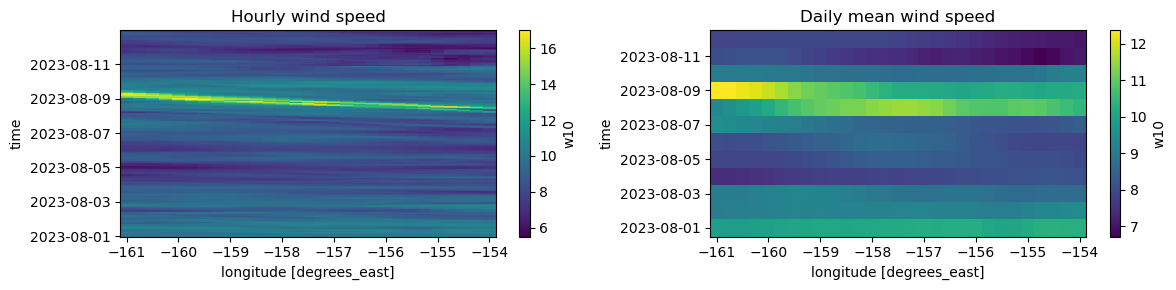

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
aug23_sfc.sel(latitude=12).w10.plot(ax=ax[0])
ax[0].set_title("Hourly wind speed")
aug23_sfc.sel(latitude=12).w10.resample(time="1D").mean().plot(ax=ax[1])
ax[1].set_title("Daily mean wind speed")
plt.tight_layout()

In [41]:
def sel_maui(ds):
    maui_lat_bnds = [21.03, 20.57]
    maui_lon_bnds = [-155.7, -156.8]
    return ds.sel(
        latitude=slice(str(maui_lat_bnds[0]), str(maui_lat_bnds[1])),
        ### Selecting by lontidue not working for some reason?? Use isel instead
        # longitude=slice(str(maui_lon_bnds[0]), str(maui_lon_bnds[1]))
    ).isel(
        longitude=range(17, 22)
    )

In [42]:
maui_aug23_sfc = sel_maui(aug23_sfc).mean(["latitude", "longitude"])
maui_aug23_1000hPa = sel_maui(aug23_1000hPa).mean(["latitude", "longitude"])

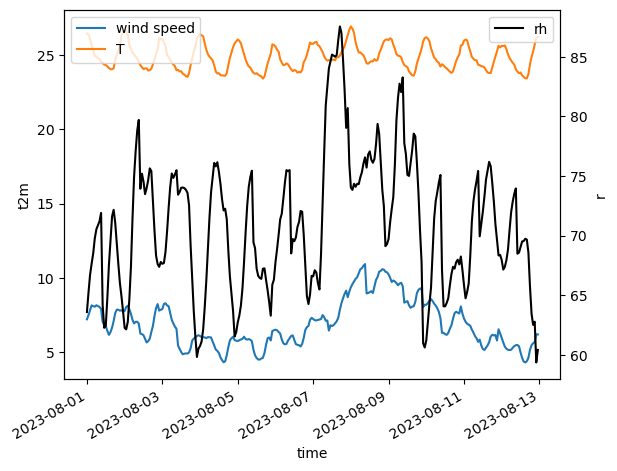

In [54]:
fig, ax = plt.subplots()
maui_aug23_sfc["w10"].plot(label="wind speed")
(maui_aug23_sfc["t2m"] - 273.15).plot(label="T")
ax2=ax.twinx()
maui_aug23_1000hPa["r"].plot(ax=ax2, c="k", label="rh")
ax.legend(loc="upper left")
ax2.legend()

### Load climatology

In [56]:
def read_era(path):
    def _preprocess(ds):
        maui_lat_bnds = [21.03, 20.57]
        maui_lon_bnds = [-155.7, -156.8]
        return ds.sel(
            latitude=slice(str(maui_lat_bnds[0]), str(maui_lat_bnds[1])),
            longitude=slice(str(maui_lon_bnds[0]), str(maui_lon_bnds[1])),
        )
    return xr.open_mfdataset(path, preprocess=_preprocess)

In [57]:
def open_yearly_data(variable, fy=1981, ly=2010):
    path = "/g/data/rt52/era5/single-levels/reanalysis/" + variable + "/"
    da_list = []
    for year in range(fy, ly):
        ds = read_era(path + str(year) + "/*.nc")
        da_list.append(ds)
    return xr.concat(da_list, dim="time")

In [58]:
t2m = open_yearly_data("2t")

In [59]:
t2m

<xarray.Dataset>
Dimensions:    (longitude: 0, latitude: 2, time: 254208)
Coordinates:
  * longitude  (longitude) float32 
  * latitude   (latitude) float32 21.0 20.75
  * time       (time) datetime64[ns] 1981-01-01 ... 2009-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(744, 2, 0), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-04 12:05:09 UTC+1100 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 19810101-19810131

In [37]:
maui_aug23_sfc#.sel(longitude=-156)

<xarray.Dataset>
Dimensions:    (longitude: 0, latitude: 2, time: 288)
Coordinates:
  * longitude  (longitude) float32 
  * latitude   (latitude) float32 21.0 20.75
  * time       (time) datetime64[ns] 2023-08-01 ... 2023-08-12T23:00:00
Data variables:
    r          (time, latitude, longitude) float32 dask.array<chunksize=(288, 2, 0), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-30 07:38:48 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [99]:
np.where(aug23_sfc.longitude.values == 

array([-161.  , -160.75, -160.5 , -160.25, -160.  , -159.75, -159.5 ,
       -159.25, -159.  , -158.75, -158.5 , -158.25, -158.  , -157.75,
       -157.5 , -157.25, -157.  , -156.75, -156.5 , -156.25, -156.  ,
       -155.75, -155.5 , -155.25, -155.  , -154.75, -154.5 , -154.25,
       -154.  ], dtype=float32)